In [1]:
from FLAI import data
from FLAI import causal_graph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas


2023-06-04 12:33:00.007115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 12:33:00.626177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-04 12:33:00.626262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-04 12:33:00.626268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
dataset_orig = load_preproc_data_german()
df = pd.DataFrame(dataset_orig.features,columns = dataset_orig.feature_names)
df['label'] = dataset_orig.labels
df.to_pickle('../Data/german.pickle')

In [3]:
dataset_orig.favorable_label

1.0

In [4]:
df.shape

(1000, 12)

## Prepare Data

In [5]:
df = pd.read_pickle('../Data/german.pickle')
df.head(5)

,age,sex,credit_history=Delay,credit_history=None/Paid,credit_history=Other,savings=500+,savings=<500,savings=Unknown/None,employment=1-4 years,employment=4+ years,employment=Unemployed,label
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0


In [6]:
df.shape

(1000, 12)

In [7]:
df.columns

Index(['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid',
       'credit_history=Other', 'savings=500+', 'savings=<500',
       'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years',
       'employment=Unemployed', 'label'],
      dtype='object')

In [8]:
df['credit_history'] = df.apply(lambda row: 0 if row['credit_history=None/Paid'] == 1 
                            else 1 if row['credit_history=Delay'] == 1 
                            else 2 if row['credit_history=Other'] == 1
                            else None,axis = 1)
df['savings'] = df.apply(lambda row: 0 if row['savings=Unknown/None'] == 1 
                                  else 1 if row['savings=<500'] == 1 
                                  else 2 if row['savings=500+'] == 1 
                                  else None,axis = 1)
df['employment'] = df.apply(lambda row: 0 if row['employment=Unemployed'] == 1 
                                  else 1 if row['employment=1-4 years'] == 1 
                                  else 2 if row['employment=4+ years'] == 1 
                                  else None,axis = 1)

#### 1 is good 2 is bad in risk.
df['label'] = df.apply(lambda row: 1 if row['label'] == 1 
                            else 0 if row['label'] == 2 
                            else None,axis = 1)

In [9]:
flai_dataset = data.Data(df[['age', 'sex', 'credit_history','savings','employment' ,'label']], transform=True)


In [10]:
flai_dataset.data.head()

,age,sex,credit_history,savings,employment,label
0,1.0,1.0,2.0,0.0,2.0,1.0
1,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,2.0,1.0,2.0,1.0
3,1.0,1.0,0.0,1.0,2.0,1.0
4,1.0,1.0,1.0,1.0,1.0,0.0


## Create Causal Graph

In [11]:
flai_graph = causal_graph.CausalGraph(flai_dataset, target = 'label')


[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
sex
employment


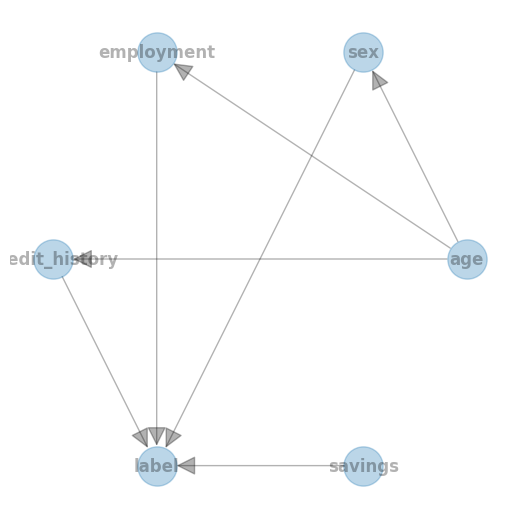

In [12]:
flai_graph.plot(directed = True)


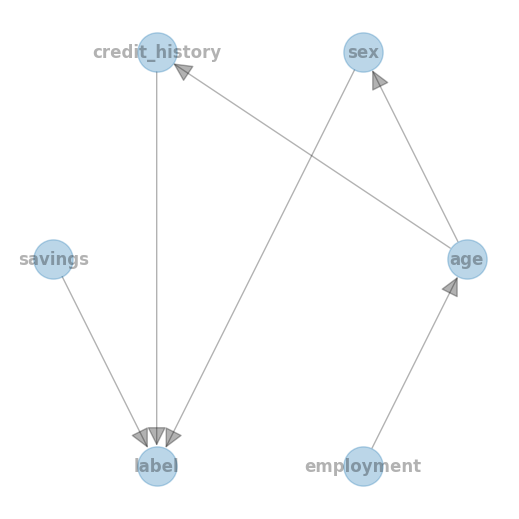

In [14]:
flai_graph.plot(directed = True)


In [15]:
flai_graph.calculate_cpd()

In [17]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'age': [19.0, 81.0],
 'sex': [31.0, 69.0],
 'credit_history': [61.9, 8.8, 29.3],
 'savings': [18.3, 70.6, 11.1],
 'label': [29.72, 70.28],
 'employment': [6.2, 51.1, 42.7]}

In [19]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.104718
1,0,1,0.205282
2,1,0,0.192519
3,1,1,0.497481


In [20]:
flai_graph.inference(variables=['age','label'], evidence={})

,age,label,p
0,0,0,0.064119
1,0,1,0.125881
2,1,0,0.233118
3,1,1,0.576882


In [21]:
data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

100%|██████████| 75/75 [00:00<00:00, 1088.30it/s]


In [22]:
result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.7,
  'TN': 3,
  'FP': 297,
  'FN': 3,
  'TP': 697,
  'TPR': 0.9957142857142857,
  'FPR': 0.99,
  'FNR': 0.004285714285714286,
  'PPP': 0.994},
 'sex': {'privileged': {'ACC': 0.7231884057971014,
   'TN': 3,
   'FP': 188,
   'FN': 3,
   'TP': 496,
   'TPR': 0.9939879759519038,
   'FPR': 0.9842931937172775,
   'FNR': 0.006012024048096192,
   'PPP': 0.991304347826087},
  'unprivileged': {'ACC': 0.6483870967741936,
   'TN': 0,
   'FP': 109,
   'FN': 0,
   'TP': 201,
   'TPR': 1.0,
   'FPR': 1.0,
   'FNR': 0.0,
   'PPP': 1.0},
  'fair_metrics': {'EOD': 0.006012024048096198,
   'DI': 1.0087719298245614,
   'SPD': 0.008695652173912993,
   'OD': 0.021718830330818673}},
 'age': {'privileged': {'ACC': 0.7283950617283951,
   'TN': 3,
   'FP': 217,
   'FN': 3,
   'TP': 587,
   'TPR': 0.9949152542372881,
   'FPR': 0.9863636363636363,
   'FNR': 0.005084745762711864,
   'PPP': 0.9925925925925926},
  'unprivileged': {'ACC': 0.5789473684210527,
   'TN': 0,
   'FP': 80,
   'FN': 0,
  

In [23]:
df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)

In [24]:
df_performance

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.700000,3.0,297.0,3.0,697.0,0.995714,0.990000,0.004286,0.994000
sex_privileged,0.723188,3.0,188.0,3.0,496.0,0.993988,0.984293,0.006012,0.991304
sex_unprivileged,0.648387,0.0,109.0,0.0,201.0,1.000000,1.000000,0.000000,1.000000
age_privileged,0.728395,3.0,217.0,3.0,587.0,0.994915,0.986364,0.005085,0.992593
age_unprivileged,0.578947,0.0,80.0,0.0,110.0,1.000000,1.000000,0.000000,1.000000


In [25]:
df_fairness

,EOD,DI,SPD,OD
sex_fair_metrics,0.006012,1.008772,0.008696,0.021719
age_fair_metrics,0.005085,1.007463,0.007407,0.018721


## Mitigate Causal Graph

In [26]:
flai_graph.mitigate_edge_relation(sensible_feature=['sex','age'])

[('age', 'credit_history'),
 ('sex', 'label'),
 ('credit_history', 'label'),
 ('savings', 'label'),
 ('age', 'label'),
 ('employment', 'credit_history'),
 ('employment', 'label'),
 ('sex', 'employment'),
 ('sex', 'credit_history'),
 ('age', 'employment')]

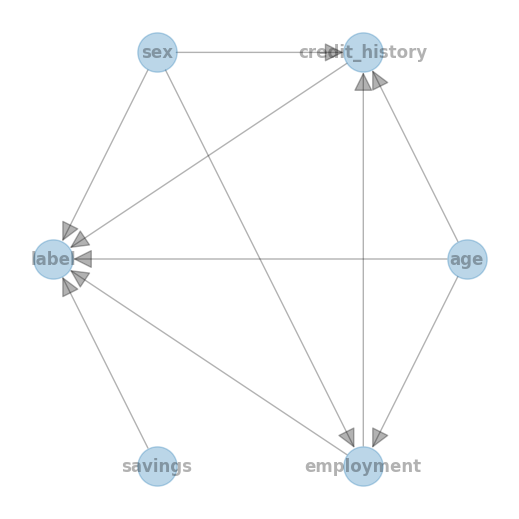

In [27]:
flai_graph.plot(directed = True)

In [28]:
flai_graph.mitigate_calculation_cpd(sensible_feature = ['age','sex'])


In [29]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'age': [50.0, 50.0],
 'credit_history': [61.9, 8.8, 29.3],
 'sex': [50.0, 50.0],
 'label': [29.96, 70.04],
 'savings': [18.3, 70.6, 11.1],
 'employment': [6.2, 51.1, 42.7]}

In [30]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.149799
1,0,1,0.350201
2,1,0,0.149799
3,1,1,0.350201


In [31]:
flai_graph.inference(variables=['age','label'], evidence={})

,age,label,p
0,0,0,0.149799
1,0,1,0.350201
2,1,0,0.149799
3,1,1,0.350201


In [32]:
data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

100%|██████████| 75/75 [00:00<00:00, 939.17it/s]


In [33]:
result_metrics_mitigated = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.702,
  'TN': 18,
  'FP': 282,
  'FN': 16,
  'TP': 684,
  'TPR': 0.9771428571428571,
  'FPR': 0.94,
  'FNR': 0.022857142857142857,
  'PPP': 0.966},
 'sex': {'privileged': {'ACC': 0.7217391304347827,
   'TN': 10,
   'FP': 181,
   'FN': 11,
   'TP': 488,
   'TPR': 0.9779559118236473,
   'FPR': 0.9476439790575916,
   'FNR': 0.022044088176352707,
   'PPP': 0.9695652173913043},
  'unprivileged': {'ACC': 0.6580645161290323,
   'TN': 8,
   'FP': 101,
   'FN': 5,
   'TP': 196,
   'TPR': 0.9751243781094527,
   'FPR': 0.926605504587156,
   'FNR': 0.024875621890547265,
   'PPP': 0.9580645161290322},
  'fair_metrics': {'EOD': -0.002831533714194534,
   'DI': 0.9881382901779256,
   'SPD': -0.011500701262272095,
   'OD': -0.023870008184630143}},
 'age': {'privileged': {'ACC': 0.7296296296296296,
   'TN': 15,
   'FP': 205,
   'FN': 14,
   'TP': 576,
   'TPR': 0.976271186440678,
   'FPR': 0.9318181818181818,
   'FNR': 0.023728813559322035,
   'PPP': 0.9641975308641976},
  'unprivileg

In [34]:
df_performance_mitigated,df_fairness_mitigated = flai_dataset.get_df_metrics(metrics_json=result_metrics_mitigated)

In [35]:
df_performance_mitigated

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.702000,18.0,282.0,16.0,684.0,0.977143,0.940000,0.022857,0.966000
sex_privileged,0.721739,10.0,181.0,11.0,488.0,0.977956,0.947644,0.022044,0.969565
sex_unprivileged,0.658065,8.0,101.0,5.0,196.0,0.975124,0.926606,0.024876,0.958065
age_privileged,0.729630,15.0,205.0,14.0,576.0,0.976271,0.931818,0.023729,0.964198
age_unprivileged,0.584211,3.0,77.0,2.0,108.0,0.981818,0.962500,0.018182,0.973684


In [36]:
df_fairness_mitigated

,EOD,DI,SPD,OD
sex_fair_metrics,-0.002832,0.988138,-0.011501,-0.023870
age_fair_metrics,0.005547,1.009839,0.009487,0.036229


In [37]:
fair_data = flai_graph.generate_dataset(n_samples = 1000*len(flai_dataset.data), methodtype = 'bayes')

                     age  credit_history       sex     label   savings  \
age             1.000000       -0.000637  0.000891  0.000353  0.001848   
credit_history -0.000637        1.000000 -0.001436  0.181056  0.001613   
sex             0.000891       -0.001436  1.000000  0.001490 -0.000709   
label           0.000353        0.181056  0.001490  1.000000 -0.021029   
savings         0.001848        0.001613 -0.000709 -0.021029  1.000000   
employment     -0.000554        0.122019  0.002233  0.091187  0.001412   

                employment  
age              -0.000554  
credit_history    0.122019  
sex               0.002233  
label             0.091187  
savings           0.001412  
employment        1.000000  


<AxesSubplot: >

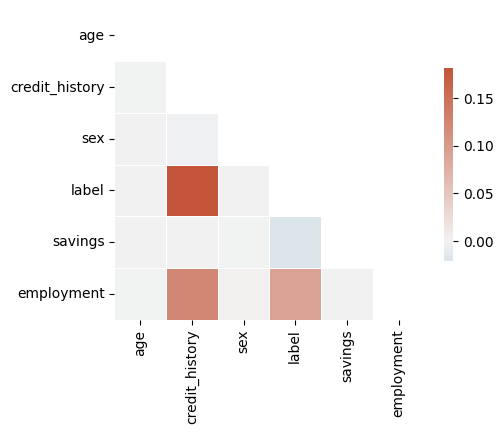

In [38]:
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = fair_data.data.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
data_pred = fair_data.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
fair_data.data['Predicted'] = out.label

100%|██████████| 108/108 [00:01<00:00, 106.67it/s]


In [40]:
result_metrics_mitigated_fair_data = fair_data.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated_fair_data

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


{'model': {'ACC': 0.703003,
  'TN': 19678,
  'FP': 279620,
  'FN': 17377,
  'TP': 683325,
  'TPR': 0.9752005845566304,
  'FPR': 0.9342528182613984,
  'FNR': 0.02479941544336965,
  'PPP': 0.962945},
 'sex': {'privileged': {'ACC': 0.7037553960856665,
   'TN': 9760,
   'FP': 139795,
   'FN': 8572,
   'TP': 342699,
   'TPR': 0.975597188495492,
   'FPR': 0.9347397278593159,
   'FNR': 0.024402811504507915,
   'PPP': 0.9633964690331572},
  'unprivileged': {'ACC': 0.7022481138841365,
   'TN': 9918,
   'FP': 139825,
   'FN': 8805,
   'TP': 340626,
   'TPR': 0.9748018922190647,
   'FPR': 0.9337665199708834,
   'FNR': 0.025198107780935293,
   'PPP': 0.9624920368448677},
  'fair_metrics': {'EOD': -0.0007952962764273819,
   'DI': 0.9990612045846533,
   'SPD': -0.0009044321882895057,
   'OD': -0.001768504164859852}},
 'age': {'privileged': {'ACC': 0.7031982090029584,
   'TN': 9827,
   'FP': 139825,
   'FN': 8659,
   'TP': 341969,
   'TPR': 0.9753043111217586,
   'FPR': 0.9343343222943896,
   'FNR': 

In [41]:
df_performance_mitigated_fair_data, df_fairness_mitigated_fair_data = fair_data.get_df_metrics(result_metrics_mitigated_fair_data)

In [42]:
df_performance_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.703003,19678.0,279620.0,17377.0,683325.0,0.975201,0.934253,0.024799,0.962945
sex_privileged,0.703755,9760.0,139795.0,8572.0,342699.0,0.975597,0.934740,0.024403,0.963396
sex_unprivileged,0.702248,9918.0,139825.0,8805.0,340626.0,0.974802,0.933767,0.025198,0.962492
age_privileged,0.703198,9827.0,139825.0,8659.0,341969.0,0.975304,0.934334,0.024696,0.963049
age_unprivileged,0.702808,9851.0,139795.0,8718.0,341356.0,0.975097,0.934171,0.024903,0.962841


In [43]:
df_fairness_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,-0.000795,0.999061,-0.000904,-0.001769
age_fair_metrics,-0.000208,0.999785,-0.000208,-0.000371


## Train Algorithm

In [50]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [51]:
original_X = flai_dataset.data[['age', 'sex', 'credit_history','savings','employment' ]]
original_y = flai_dataset.data[['label']]
mitigated_X = fair_data.data[['age', 'sex', 'credit_history','savings','employment' ]]
mitigated_y = fair_data.data[['label']]


In [52]:
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(original_X, original_y, test_size=0.5, random_state=54)
mitigated_X_train, mitigated_X_test, mitigated_y_train, mitigated_y_test = train_test_split(mitigated_X, mitigated_y, test_size=0.5, random_state=54)


In [53]:
model_original = XGBClassifier()
model_original.fit(original_X_train, original_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [54]:
model_mitigated = XGBClassifier()
model_mitigated.fit(mitigated_X_train, mitigated_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [55]:
original_y_test['Predicted'] = model_original.predict(original_X_test)
mitigated_y_test['Predicted'] = model_mitigated.predict(mitigated_X_test)

In [56]:
original_X_test[['label', 'Predicted']] = original_y_test[['label', 'Predicted']]
mitigated_X_test[['label', 'Predicted']] = mitigated_y_test[['label', 'Predicted']]


In [57]:
original_dataset = data.Data(original_X_test, transform=False)
mitigated_dataset = data.Data(mitigated_X_test, transform=False)

In [58]:
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [59]:
df_performance_xgboost

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.712000,26.0,112.0,32.0,330.0,0.911602,0.811594,0.088398,0.884000
sex_privileged,0.734870,11.0,71.0,21.0,244.0,0.920755,0.865854,0.079245,0.907781
sex_unprivileged,0.660131,15.0,41.0,11.0,86.0,0.886598,0.732143,0.113402,0.830065
age_privileged,0.727711,9.0,95.0,18.0,293.0,0.942122,0.913462,0.057878,0.934940
age_unprivileged,0.635294,17.0,17.0,14.0,37.0,0.725490,0.500000,0.274510,0.635294


In [60]:
df_fairness_xgboost

,EOD,DI,SPD,OD
sex_fair_metrics,-0.034157,0.914389,-0.077716,-0.167868
age_fair_metrics,-0.216632,0.679503,-0.299646,-0.630094


In [61]:
metrics_xgboost_mitigated_fair_data = mitigated_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost_mitigated_fair_data,df_fairness_xgboost_mitigated_fair_data = original_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [62]:
df_performance_xgboost_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.703836,8694.0,140482.0,7600.0,343224.0,0.978337,0.941720,0.021663,0.967412
sex_privileged,0.705058,4134.0,70343.0,3560.0,172531.0,0.979783,0.944493,0.020217,0.969294
sex_unprivileged,0.702608,4560.0,70139.0,4040.0,170693.0,0.976879,0.938955,0.023121,0.965522
age_privileged,0.703822,3911.0,70842.0,3324.0,172333.0,0.981077,0.947681,0.018923,0.971107
age_unprivileged,0.703850,4783.0,69640.0,4276.0,170891.0,0.975589,0.935732,0.024411,0.963704


In [63]:
df_fairness_xgboost_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,-0.002904,0.996108,-0.003772,-0.008442
age_fair_metrics,-0.005488,0.992377,-0.007403,-0.017437


In [64]:
original_y_test['Predicted'] = model_mitigated.predict(original_X_test[['age', 'sex', 'credit_history','savings','employment']])
original_X_test[['label', 'Predicted']] = original_y_test[['label', 'Predicted']]
original_dataset = data.Data(original_X_test, transform=False)
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'age' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : age  the value :  1
Calculating metrics for : age  the value :  0


In [65]:
df_performance_xgboost

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.718000,6.0,132.0,9.0,353.0,0.975138,0.956522,0.024862,0.970000
sex_privileged,0.755043,3.0,79.0,6.0,259.0,0.977358,0.963415,0.022642,0.974063
sex_unprivileged,0.633987,3.0,53.0,3.0,94.0,0.969072,0.946429,0.030928,0.960784
age_privileged,0.742169,4.0,100.0,7.0,304.0,0.977492,0.961538,0.022508,0.973494
age_unprivileged,0.600000,2.0,32.0,2.0,49.0,0.960784,0.941176,0.039216,0.952941


In [66]:
df_fairness_xgboost

,EOD,DI,SPD,OD
sex_fair_metrics,-0.008286,0.986367,-0.013279,-0.025272
age_fair_metrics,-0.016708,0.978888,-0.020553,-0.037070


### Explain Results

In [130]:
import shap

In [131]:
explainer_original = shap.Explainer(model_original)
explainer_mitigated = shap.Explainer(model_mitigated)

In [132]:
shap_values_orignal = explainer_original(original_dataset.data[['age', 'sex', 'credit_history','savings','employment']])
shap_values_mitigated = explainer_mitigated(original_dataset.data[['age', 'sex', 'credit_history','savings','employment']])
shap_interaction = explainer_mitigated.shap_interaction_values(original_dataset.data[['age', 'sex', 'credit_history','savings','employment']])

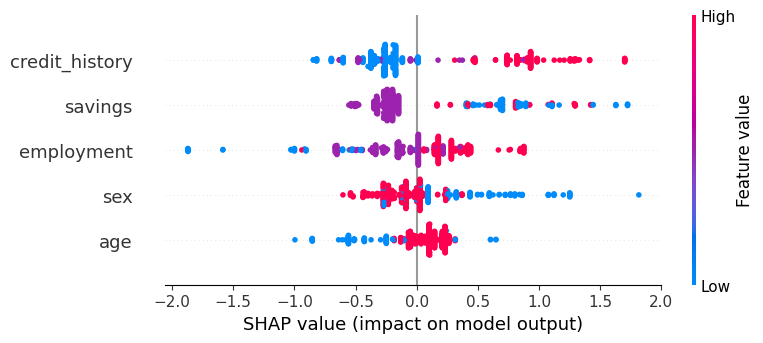

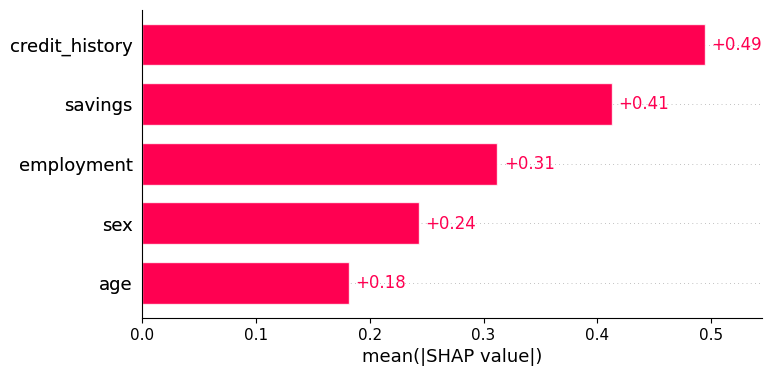

In [133]:
shap.plots.beeswarm(shap_values_orignal)
shap.plots.bar(shap_values_orignal)

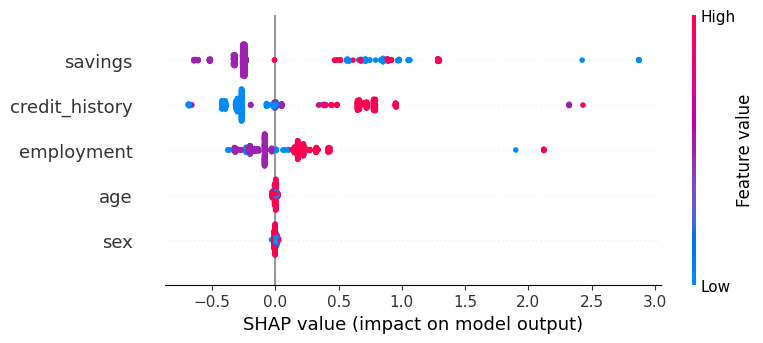

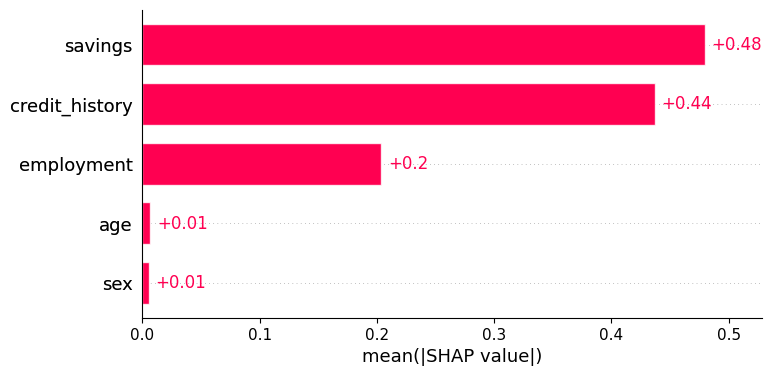

In [134]:
shap.plots.beeswarm(shap_values_mitigated)
shap.plots.bar(shap_values_mitigated)

In [135]:
shap_values_model_mitigated_dataset = explainer_original(mitigated_dataset.data[['age', 'sex', 'credit_history','savings','employment']])
shap_values_mitigated_dataset = explainer_mitigated(mitigated_dataset.data[['age', 'sex', 'credit_history','savings','employment']])

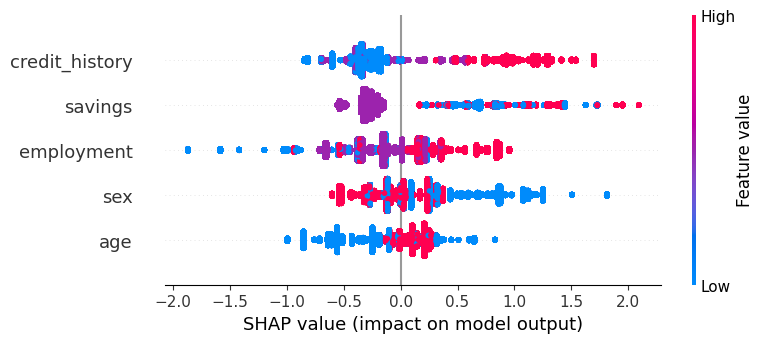

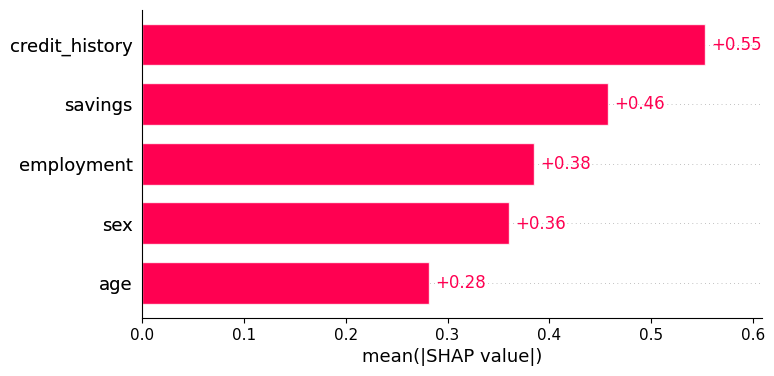

In [136]:
shap.plots.beeswarm(shap_values_model_mitigated_dataset)
shap.plots.bar(shap_values_model_mitigated_dataset)

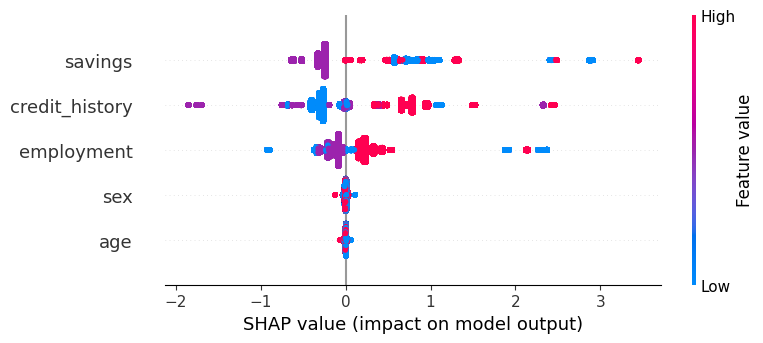

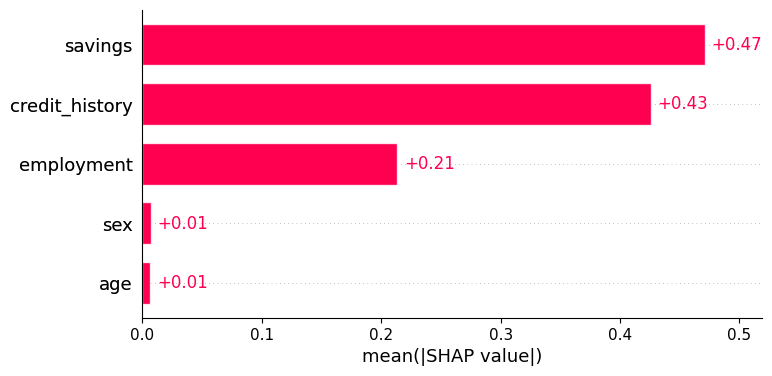

In [137]:
shap.plots.beeswarm(shap_values_mitigated_dataset)
shap.plots.bar(shap_values_mitigated_dataset)

### Test other algorithm

In [ ]:
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc



In [ ]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

In [ ]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [ ]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [ ]:
optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
OP = OptimPreproc(OptTools, optim_options)

OP = OP.fit(dataset_orig_train)
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

Optimized Preprocessing: Objective converged to 0.010890


                age  education       sex      race     label
age        1.000000   0.026878  0.087111  0.027662  0.228793
education  0.026878   1.000000 -0.001475  0.034768  0.317179
sex        0.087111  -0.001475  1.000000  0.134281  0.058479
race       0.027662   0.034768  0.134281  1.000000  0.046588
label      0.228793   0.317179  0.058479  0.046588  1.000000


<AxesSubplot: >

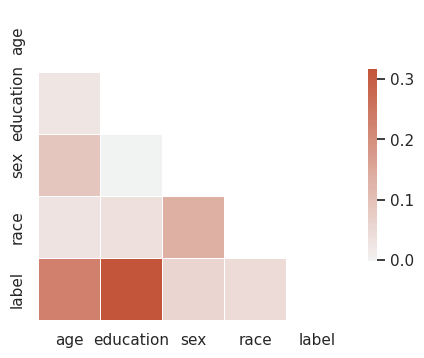

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_transf_train.features,columns = dataset_transf_train.feature_names)

df_train_transf['label'] = dataset_transf_train.labels
df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_train_transf = df_train_transf[['age','education','sex','race','label']]
# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
model_op = XGBClassifier()
model_op.fit(dataset_transf_train.features, dataset_transf_train.labels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
df_op = pd.DataFrame(dataset_orig_test.features,columns=dataset_orig_test.feature_names)
df_op['label'] = dataset_orig_test.labels
df_op['Predicted'] = model_op.predict(dataset_orig_test.features)


In [ ]:
op_dataset = data.Data(df_op, transform=False)

metrics_xgboost_mitigated_fair_data = op_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = op_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [ ]:
   
compute_metrics(dataset_transf_train, dataset_transf_train, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 1.0000
Statistical parity difference = -0.0537
Disparate impact = 0.7985
Average odds difference = 0.0000
Equal opportunity difference = 0.0000
Theil index = 0.0000


OrderedDict([('Balanced accuracy', 1.0),
             ('Statistical parity difference', -0.05372425512545234),
             ('Disparate impact', 0.7985384483513088),
             ('Average odds difference', 0.0),
             ('Equal opportunity difference', 0.0),
             ('Theil index', 0.0)])

In [ ]:
df_performance_op

,ACC,TPR,FPR,FNR,PPP
model,0.780864,0.424712,0.105135,0.575288,0.182625
sex_privileged,0.752223,0.417517,0.097095,0.582483,0.196565
sex_unprivileged,0.838398,0.467054,0.117593,0.532946,0.154620
race_privileged,0.774004,0.453818,0.114448,0.546182,0.202132
race_unprivileged,0.822286,0.114754,0.056275,0.885246,0.064841


In [ ]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,0.049537,0.786609,-0.041945,0.070035
race_fair_metrics,-0.339064,0.320788,-0.137290,-0.397237


In [ ]:
explainer_op = shap.Explainer(model_op)


In [ ]:
shap_values_op = explainer_op(pd.DataFrame(dataset_orig_test.features,columns=dataset_orig_test.feature_names))


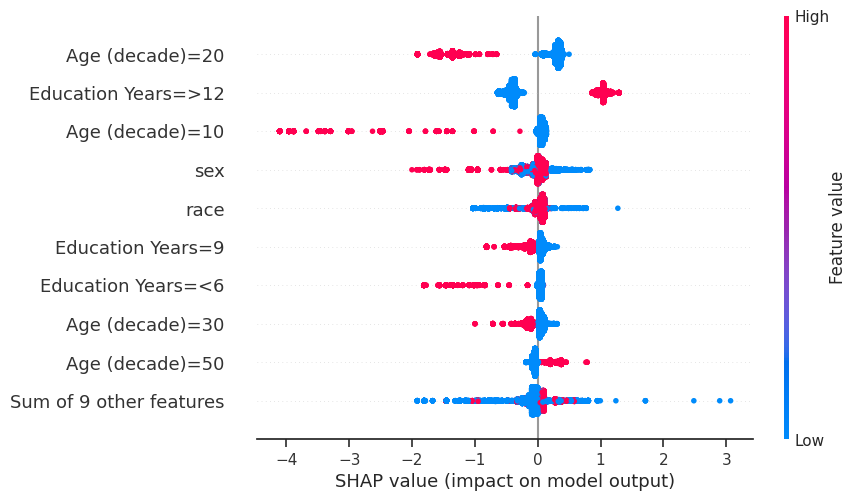

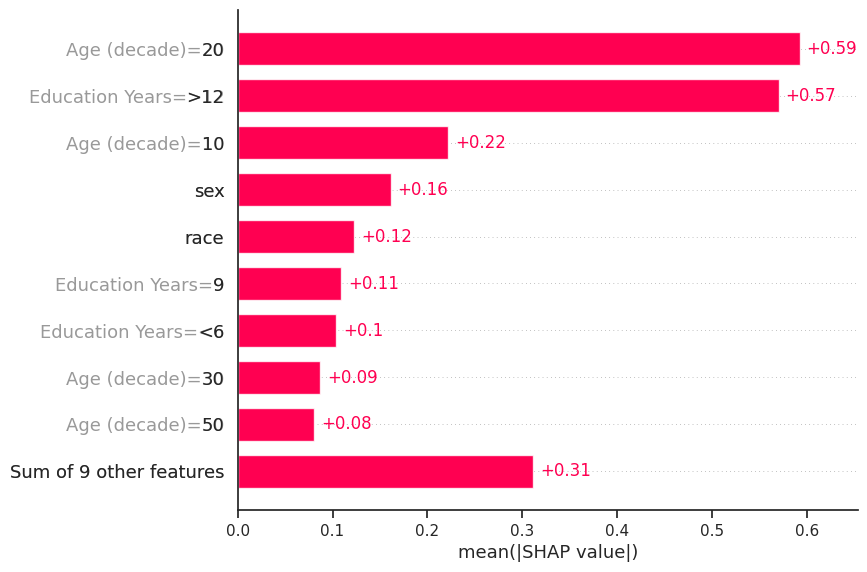

In [ ]:
shap.plots.beeswarm(shap_values_op)
shap.plots.bar(shap_values_op)